# Exploratory Data Analysis (EDA)

## Imports and loading data

In [101]:
import os
import sqlite3
import pandas as pd
import pytz
from google.colab import drive
import matplotlib.pyplot as plt
import missingno as msno
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
#import seaborn as sns

# Mount Google Drive (must happen before path setup)
drive.mount('/content/drive', force_remount=True)

# Define file paths
drive_path = "/content/drive/MyDrive/Colab-Notebooks/last-fm-data"
data_path = os.path.join(drive_path, "data")
DB_PATH = os.path.join(data_path, "lastfm_data.db")

Mounted at /content/drive


In [102]:
# Connect to the database
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

## Initial data inspection

In [103]:
# Get table names
df_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
table_names = df_tables['name'].tolist()

print("\nAvailable tables (pandas method):")
print(df_tables)


Available tables (pandas method):
                      name
0                  artists
1                   albums
2                   tracks
3                     tags
4              artist_tags
5               album_tags
6               track_tags
7           artist_similar
8            track_similar
9   user_listening_history
10        user_top_artists
11         user_top_albums
12         user_top_tracks


In [104]:
def explore_table(table_name):
    # Get schema information
    schema_df = pd.read_sql_query(f"PRAGMA table_info({table_name});", conn)
    print(f"\nSchema for table '{table_name}':")
    print(schema_df[['name', 'type']])

    # Get row count
    count_df = pd.read_sql_query(f"SELECT COUNT(*) as count FROM {table_name};", conn)
    print(f"\nRow count: {count_df['count'].iloc[0]}") # Why does this work

    # Preview data
    preview_df = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT 5;", conn)
    print(f"\nPreview of '{table_name}':")
    return preview_df

table = explore_table(table_names[10]) # Change to preview table no
display(table)


Schema for table 'user_top_artists':
                 name       type
0  user_top_artist_id    INTEGER
1           artist_id    INTEGER
2         time_period       TEXT
3                rank    INTEGER
4           playcount    INTEGER
5          created_at  TIMESTAMP
6          updated_at  TIMESTAMP

Row count: 261

Preview of 'user_top_artists':


,user_top_artist_id,artist_id,time_period,rank,playcount,created_at,updated_at
0,1,440,overall,1,1370,2025-05-08 17:24:25,2025-05-08 17:24:25
1,2,635,overall,2,1145,2025-05-08 17:24:25,2025-05-08 17:24:25
2,3,290,overall,3,856,2025-05-08 17:24:25,2025-05-08 17:24:25
3,4,435,overall,4,811,2025-05-08 17:24:25,2025-05-08 17:24:25
4,5,295,overall,5,755,2025-05-08 17:24:25,2025-05-08 17:24:25


## Check dimensions and data types

In [105]:
def explore_all_tables(conn):
    """
    Explore all tables in the database and return a summary.

    Parameters:
    conn - SQLite database connection

    Returns:
    Dictionary with table names as keys and their complete dataframes as values
    """
    # Get all table names
    tables_df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
    table_names = tables_df['name'].tolist()

    if not table_names:
        print("No tables found in the database.")
        return {}

    print(f"Found {len(table_names)} tables in the database.\n")

    # Dictionary to store preview dataframes
    tables = {}

    # Process each table
    for table_name in table_names:
        print(f"\n{'='*50}")
        print(f"TABLE: {table_name}")
        print(f"{'='*50}")

        # Get schema information
        schema_df = pd.read_sql_query(f"PRAGMA table_info({table_name});", conn)
        print(f"Schema:")
        print(schema_df[['name', 'type']])

        # Get row count
        count_df = pd.read_sql_query(f"SELECT COUNT(*) as count FROM {table_name};", conn)
        row_count = count_df['count'].iloc[0]
        print(f"\nRow count: {row_count}")

        # Get column count
        col_count = len(schema_df)
        print(f"Column count: {col_count}")

        # Check for null values
        if row_count > 0:
            null_counts = pd.read_sql_query(
                f"SELECT {', '.join([f'SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS {col}_nulls' for col in schema_df['name']])} FROM {table_name};",
                conn
            )
            print("\nNull values per column:")
            print(null_counts)

        # Preview data
        preview_df = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT 5;", conn)
        print(f"\nPreview of data:")
        display(preview_df)

        full_df = pd.read_sql_query(f"SELECT * FROM {table_name};", conn)

        # Store the full tables
        tables[table_name] = full_df

    return tables

# Example usage:
table_data = explore_all_tables(conn)

Found 13 tables in the database.


TABLE: artists
Schema:
            name       type
0      artist_id    INTEGER
1           name       TEXT
2           mbid       TEXT
3            url       TEXT
4    image_small       TEXT
5   image_medium       TEXT
6    image_large       TEXT
7      listeners    INTEGER
8      playcount    INTEGER
9    bio_summary       TEXT
10   bio_content       TEXT
11    created_at  TIMESTAMP
12    updated_at  TIMESTAMP

Row count: 659
Column count: 13

Null values per column:
   artist_id_nulls  name_nulls  mbid_nulls  url_nulls  image_small_nulls  \
0                0           0           0          0                  0   

   image_medium_nulls  image_large_nulls  listeners_nulls  playcount_nulls  \
0                   0                  0                0                0   

   bio_summary_nulls  bio_content_nulls  created_at_nulls  updated_at_nulls  
0                  0                  0                 0                 0  

Preview of data:


,artist_id,name,mbid,url,image_small,image_medium,image_large,listeners,playcount,bio_summary,bio_content,created_at,updated_at
0,1,exploding heart,,https://www.last.fm/music/exploding+heart,https://lastfm.freetls.fastly.net/i/u/34s/2a96...,https://lastfm.freetls.fastly.net/i/u/64s/2a96...,https://lastfm.freetls.fastly.net/i/u/174s/2a9...,3337,20339,"<a href=""https://www.last.fm/music/exploding+...",,2025-05-08 17:24:21,2025-05-08 17:24:21
1,2,Nouri,66e87b9b-c7fd-49c3-ba0c-00d63e86e73a,https://www.last.fm/music/Nouri,https://lastfm.freetls.fastly.net/i/u/34s/2a96...,https://lastfm.freetls.fastly.net/i/u/64s/2a96...,https://lastfm.freetls.fastly.net/i/u/174s/2a9...,38188,111172,"Vivian Nouri, born February 10, 1993 in Kurdis...","Vivian Nouri, born February 10, 1993 in Kurdis...",2025-05-08 17:24:21,2025-05-08 17:24:21
2,3,Sofie Royer,,https://www.last.fm/music/Sofie+Royer,https://lastfm.freetls.fastly.net/i/u/34s/2a96...,https://lastfm.freetls.fastly.net/i/u/64s/2a96...,https://lastfm.freetls.fastly.net/i/u/174s/2a9...,74861,515934,"Sofie Royer, who previously released music as ...","Sofie Royer, who previously released music as ...",2025-05-08 17:24:21,2025-05-08 17:24:21
3,4,Okonski,,https://www.last.fm/music/Okonski,https://lastfm.freetls.fastly.net/i/u/34s/2a96...,https://lastfm.freetls.fastly.net/i/u/64s/2a96...,https://lastfm.freetls.fastly.net/i/u/174s/2a9...,26834,153753,The studio at 122 West Loveland Avenue was not...,The studio at 122 West Loveland Avenue was not...,2025-05-08 17:24:21,2025-05-08 17:24:21
4,5,Leoš Janáček,edfced8a-01bc-4c22-96b2-da58edd6b8af,https://www.last.fm/music/+noredirect/Leo%C5%A...,https://lastfm.freetls.fastly.net/i/u/34s/2a96...,https://lastfm.freetls.fastly.net/i/u/64s/2a96...,https://lastfm.freetls.fastly.net/i/u/174s/2a9...,223776,1636503,Leoš Janáček (3 July 1854 in Hukvaldy – 12 Aug...,Leoš Janáček (3 July 1854 in Hukvaldy – 12 Aug...,2025-05-08 17:24:21,2025-05-08 17:24:21



TABLE: albums
Schema:
            name       type
0       album_id    INTEGER
1      artist_id    INTEGER
2           name       TEXT
3           mbid       TEXT
4            url       TEXT
5    image_small       TEXT
6   image_medium       TEXT
7    image_large       TEXT
8      listeners    INTEGER
9      playcount    INTEGER
10  release_date       DATE
11    created_at  TIMESTAMP
12    updated_at  TIMESTAMP

Row count: 1210
Column count: 13

Null values per column:
   album_id_nulls  artist_id_nulls  name_nulls  mbid_nulls  url_nulls  \
0               0                0           0           0          0   

   image_small_nulls  image_medium_nulls  image_large_nulls  listeners_nulls  \
0                  0                   0                  0                0   

   playcount_nulls  release_date_nulls  created_at_nulls  updated_at_nulls  
0                0                1210                 0                 0  

Preview of data:


,album_id,artist_id,name,mbid,url,image_small,image_medium,image_large,listeners,playcount,release_date,created_at,updated_at
0,1,345,Mi sei scoppiato dentro il cuore,bbe7ed8f-ff97-493b-b7c1-caf5bbd7550c,https://www.last.fm/music/Mina/Mi+sei+scoppiat...,https://lastfm.freetls.fastly.net/i/u/34s/6abe...,https://lastfm.freetls.fastly.net/i/u/64s/6abe...,https://lastfm.freetls.fastly.net/i/u/174s/6ab...,10545,60165,None,2025-05-08 17:24:21,2025-05-08 17:24:21
1,2,650,Black Devil Disco Club Presents: Cosmos 2043,,https://www.last.fm/music/Bernard+Fevre/Black+...,https://lastfm.freetls.fastly.net/i/u/34s/90f6...,https://lastfm.freetls.fastly.net/i/u/64s/90f6...,https://lastfm.freetls.fastly.net/i/u/174s/90f...,22725,89010,None,2025-05-08 17:24:21,2025-05-08 17:24:21
2,3,127,Tekno,5d2d22c5-53c4-4b01-8261-c539da884ad0,https://www.last.fm/music/1900/Tekno,https://lastfm.freetls.fastly.net/i/u/34s/850e...,https://lastfm.freetls.fastly.net/i/u/64s/850e...,https://lastfm.freetls.fastly.net/i/u/174s/850...,21713,219208,None,2025-05-08 17:24:21,2025-05-08 17:24:21
3,4,253,Sing We Christmas,,https://www.last.fm/music/Tom%C3%A1s+Luis+de+V...,,,,61,113,None,2025-05-08 17:24:21,2025-05-08 17:24:21
4,5,508,High Violet (Expanded Edition),,https://www.last.fm/music/The+National/High+Vi...,https://lastfm.freetls.fastly.net/i/u/34s/b4d1...,https://lastfm.freetls.fastly.net/i/u/64s/b4d1...,https://lastfm.freetls.fastly.net/i/u/174s/b4d...,295534,7601723,None,2025-05-08 17:24:21,2025-05-08 17:24:21



TABLE: tracks
Schema:
          name       type
0     track_id    INTEGER
1    artist_id    INTEGER
2     album_id    INTEGER
3         name       TEXT
4         mbid       TEXT
5          url       TEXT
6     duration    INTEGER
7    listeners    INTEGER
8    playcount    INTEGER
9   created_at  TIMESTAMP
10  updated_at  TIMESTAMP

Row count: 1666
Column count: 11

Null values per column:
   track_id_nulls  artist_id_nulls  album_id_nulls  name_nulls  mbid_nulls  \
0               0                0             560           0           0   

   url_nulls  duration_nulls  listeners_nulls  playcount_nulls  \
0          0               0                0                0   

   created_at_nulls  updated_at_nulls  
0                 0                 0  

Preview of data:


,track_id,artist_id,album_id,name,mbid,url,duration,listeners,playcount,created_at,updated_at
0,1,643,NaN,"O Venezia, Venaga, Venusia #3 - Remastered 2022",,https://www.last.fm/music/Nino+Rota/_/O+Venezi...,0,20,29,2025-05-08 17:24:22,2025-05-08 17:24:22
1,2,112,870.0,Clouds,,https://www.last.fm/music/Maria+Chiara+Argir%C...,161000,12862,36181,2025-05-08 17:24:22,2025-05-08 17:24:22
2,3,201,NaN,Stay With Me Through The Night,,https://www.last.fm/music/Fabiana+Palladino/_/...,0,21245,88343,2025-05-08 17:24:22,2025-05-08 17:24:22
3,4,482,424.0,Happy New Year,,https://www.last.fm/music/Arny+Margret/_/Happy...,189000,969,2275,2025-05-08 17:24:22,2025-05-08 17:24:22
4,5,582,360.0,the locked room,,https://www.last.fm/music/Jun+Miyake/_/the+loc...,170000,7286,24513,2025-05-08 17:24:22,2025-05-08 17:24:22



TABLE: tags
Schema:
           name       type
0        tag_id    INTEGER
1          name       TEXT
2           url       TEXT
3         reach    INTEGER
4      taggings    INTEGER
5  wiki_summary       TEXT
6  wiki_content       TEXT
7    created_at  TIMESTAMP
8    updated_at  TIMESTAMP

Row count: 11764
Column count: 9

Null values per column:
   tag_id_nulls  name_nulls  url_nulls  reach_nulls  taggings_nulls  \
0             0           0          0            0               0   

   wiki_summary_nulls  wiki_content_nulls  created_at_nulls  updated_at_nulls  
0                   0                   0                 0                 0  

Preview of data:


,tag_id,name,url,reach,taggings,wiki_summary,wiki_content,created_at,updated_at
0,1,seen live,https://www.last.fm/tag/seen+live,82511,2184342,**** IF YOU ARE A USER WHO WANTS TO VIEW THEIR...,**** IF YOU ARE A USER WHO WANTS TO VIEW THEIR...,2025-05-08 17:24:04,2025-05-08 17:24:04
1,2,indie,https://www.last.fm/tag/indie,259634,2059970,The term 'indie' is best known as being an abb...,The term 'indie' is best known as being an abb...,2025-05-08 17:24:04,2025-05-08 17:24:04
2,3,swedish,https://www.last.fm/tag/swedish,43984,247569,Swedish music is produced by ethnic Swedes or ...,Swedish music is produced by ethnic Swedes or ...,2025-05-08 17:24:04,2025-05-08 17:24:04
3,4,Dreamy,https://www.last.fm/tag/Dreamy,13098,64702,"Dreamy Musical Sounds <a href=""http://www.last...","Dreamy Musical Sounds <a href=""http://www.last...",2025-05-08 17:24:04,2025-05-08 17:24:04
4,5,melancholic,https://www.last.fm/tag/melancholic,22938,120935,Melancholia is a state of emotion. The tag ser...,Melancholia is a state of emotion. The tag ser...,2025-05-08 17:24:04,2025-05-08 17:24:04



TABLE: artist_tags
Schema:
         name       type
0   artist_id    INTEGER
1      tag_id    INTEGER
2       count    INTEGER
3  created_at  TIMESTAMP

Row count: 22852
Column count: 4

Null values per column:
   artist_id_nulls  tag_id_nulls  count_nulls  created_at_nulls
0                0             0            0                 0

Preview of data:


,artist_id,tag_id,count,created_at
0,1,1,100,2025-05-08 17:24:23
1,1,2,100,2025-05-08 17:24:23
2,1,3,100,2025-05-08 17:24:23
3,1,4,75,2025-05-08 17:24:23
4,1,5,75,2025-05-08 17:24:23



TABLE: album_tags
Schema:
         name       type
0    album_id    INTEGER
1      tag_id    INTEGER
2       count    INTEGER
3  created_at  TIMESTAMP

Row count: 8511
Column count: 4

Null values per column:
   album_id_nulls  tag_id_nulls  count_nulls  created_at_nulls
0               0             0            0                 0

Preview of data:


,album_id,tag_id,count,created_at
0,5,264,100,2025-05-08 17:24:24
1,5,2,50,2025-05-08 17:24:24
2,5,268,50,2025-05-08 17:24:24
3,5,537,50,2025-05-08 17:24:24
4,5,949,50,2025-05-08 17:24:24



TABLE: track_tags
Schema:
         name       type
0    track_id    INTEGER
1      tag_id    INTEGER
2       count    INTEGER
3  created_at  TIMESTAMP

Row count: 13499
Column count: 4

Null values per column:
   track_id_nulls  tag_id_nulls  count_nulls  created_at_nulls
0               0             0            0                 0

Preview of data:


,track_id,tag_id,count,created_at
0,2,8122,100,2025-05-08 17:24:24
1,5,8123,100,2025-05-08 17:24:24
2,5,8124,100,2025-05-08 17:24:24
3,5,8125,100,2025-05-08 17:24:24
4,5,8126,100,2025-05-08 17:24:24



TABLE: artist_similar
Schema:
                name       type
0          artist_id    INTEGER
1  similar_artist_id    INTEGER
2        match_score       REAL
3         created_at  TIMESTAMP

Row count: 1048
Column count: 4

Null values per column:
   artist_id_nulls  similar_artist_id_nulls  match_score_nulls  \
0                0                        0                  0   

   created_at_nulls  
0                 0  

Preview of data:


,artist_id,similar_artist_id,match_score,created_at
0,5,10,1.000000,2025-05-08 17:24:24
1,5,246,0.795431,2025-05-08 17:24:24
2,7,57,1.000000,2025-05-08 17:24:24
3,7,615,0.913133,2025-05-08 17:24:24
4,7,638,0.833907,2025-05-08 17:24:24



TABLE: track_similar
Schema:
               name       type
0          track_id    INTEGER
1  similar_track_id    INTEGER
2       match_score       REAL
3        created_at  TIMESTAMP

Row count: 992
Column count: 4

Null values per column:
   track_id_nulls  similar_track_id_nulls  match_score_nulls  created_at_nulls
0               0                       0                  0                 0

Preview of data:


,track_id,similar_track_id,match_score,created_at
0,7,319,0.120796,2025-05-08 17:24:24
1,13,1643,1.000000,2025-05-08 17:24:24
2,13,112,0.911135,2025-05-08 17:24:24
3,15,632,1.000000,2025-05-08 17:24:24
4,15,628,0.510045,2025-05-08 17:24:24



TABLE: user_listening_history
Schema:
             name       type
0      history_id    INTEGER
1        track_id    INTEGER
2     listened_at  TIMESTAMP
3  is_now_playing    BOOLEAN
4      created_at  TIMESTAMP

Row count: 2000
Column count: 5

Null values per column:
   history_id_nulls  track_id_nulls  listened_at_nulls  is_now_playing_nulls  \
0                 0               0                  0                     0   

   created_at_nulls  
0                 0  

Preview of data:


,history_id,track_id,listened_at,is_now_playing,created_at
0,1,82,2025-05-07 08:39:43,0,2025-05-08 17:24:24
1,2,58,2025-05-07 08:36:23,0,2025-05-08 17:24:24
2,3,907,2025-05-07 08:35:03,0,2025-05-08 17:24:24
3,4,449,2025-05-07 08:32:06,0,2025-05-08 17:24:24
4,5,1592,2025-05-07 08:27:36,0,2025-05-08 17:24:24



TABLE: user_top_artists
Schema:
                 name       type
0  user_top_artist_id    INTEGER
1           artist_id    INTEGER
2         time_period       TEXT
3                rank    INTEGER
4           playcount    INTEGER
5          created_at  TIMESTAMP
6          updated_at  TIMESTAMP

Row count: 261
Column count: 7

Null values per column:
   user_top_artist_id_nulls  artist_id_nulls  time_period_nulls  rank_nulls  \
0                         0                0                  0           0   

   playcount_nulls  created_at_nulls  updated_at_nulls  
0                0                 0                 0  

Preview of data:


,user_top_artist_id,artist_id,time_period,rank,playcount,created_at,updated_at
0,1,440,overall,1,1370,2025-05-08 17:24:25,2025-05-08 17:24:25
1,2,635,overall,2,1145,2025-05-08 17:24:25,2025-05-08 17:24:25
2,3,290,overall,3,856,2025-05-08 17:24:25,2025-05-08 17:24:25
3,4,435,overall,4,811,2025-05-08 17:24:25,2025-05-08 17:24:25
4,5,295,overall,5,755,2025-05-08 17:24:25,2025-05-08 17:24:25



TABLE: user_top_albums
Schema:
                name       type
0  user_top_album_id    INTEGER
1           album_id    INTEGER
2        time_period       TEXT
3               rank    INTEGER
4          playcount    INTEGER
5         created_at  TIMESTAMP
6         updated_at  TIMESTAMP

Row count: 268
Column count: 7

Null values per column:
   user_top_album_id_nulls  album_id_nulls  time_period_nulls  rank_nulls  \
0                        0               0                  0           0   

   playcount_nulls  created_at_nulls  updated_at_nulls  
0                0                 0                 0  

Preview of data:


,user_top_album_id,album_id,time_period,rank,playcount,created_at,updated_at
0,1,562,overall,1,435,2025-05-08 17:24:25,2025-05-08 17:24:25
1,2,272,overall,2,366,2025-05-08 17:24:25,2025-05-08 17:24:25
2,3,104,overall,3,346,2025-05-08 17:24:25,2025-05-08 17:24:25
3,4,245,overall,4,268,2025-05-08 17:24:25,2025-05-08 17:24:25
4,5,217,overall,5,266,2025-05-08 17:24:25,2025-05-08 17:24:25



TABLE: user_top_tracks
Schema:
                name       type
0  user_top_track_id    INTEGER
1           track_id    INTEGER
2        time_period       TEXT
3               rank    INTEGER
4          playcount    INTEGER
5         created_at  TIMESTAMP
6         updated_at  TIMESTAMP

Row count: 300
Column count: 7

Null values per column:
   user_top_track_id_nulls  track_id_nulls  time_period_nulls  rank_nulls  \
0                        0               0                  0           0   

   playcount_nulls  created_at_nulls  updated_at_nulls  
0                0                 0                 0  

Preview of data:


,user_top_track_id,track_id,time_period,rank,playcount,created_at,updated_at
0,1,637,overall,1,234,2025-05-08 17:24:25,2025-05-08 17:24:25
1,2,698,overall,2,212,2025-05-08 17:24:25,2025-05-08 17:24:25
2,3,115,overall,3,133,2025-05-08 17:24:25,2025-05-08 17:24:25
3,4,732,overall,4,87,2025-05-08 17:24:25,2025-05-08 17:24:25
4,5,621,overall,5,79,2025-05-08 17:24:25,2025-05-08 17:24:25


In [106]:
# Verify data types and adjust accordingly
table_data['albums'].info() #table_data['albums'].dtypes
# Timestamps are objects in all tables, should be datetime

date_columns = {
    'albums': ['created_at', 'updated_at'],
    'artists': ['created_at', 'updated_at'],
    'tracks': ['created_at', 'updated_at'],
    'tags': ['created_at', 'updated_at'],
    'user_top_artists': ['created_at', 'updated_at'],
    'user_top_albums': ['created_at', 'updated_at'],
    'user_top_tracks': ['created_at', 'updated_at'],
    'artist_tags': ['created_at'],
    'track_tags': ['created_at'],
    'artist_similar': ['created_at'],
    'track_similar': ['created_at'],
    'user_listening_history': ['created_at', 'listened_at']
}

# Convert all at once
for table_name, date_cols in date_columns.items():
    table_data[table_name][date_cols] = table_data[table_name][date_cols].apply(pd.to_datetime)

# Use category dtype for time_period column
for table in ['user_top_tracks', 'user_top_albums', 'user_top_artists']:
    table_data[table]['time_period'] = table_data[table]['time_period'].astype('category')

# Check that it worked
table_data['user_top_tracks'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210 entries, 0 to 1209
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   album_id      1210 non-null   int64 
 1   artist_id     1210 non-null   int64 
 2   name          1210 non-null   object
 3   mbid          1210 non-null   object
 4   url           1210 non-null   object
 5   image_small   1210 non-null   object
 6   image_medium  1210 non-null   object
 7   image_large   1210 non-null   object
 8   listeners     1210 non-null   int64 
 9   playcount     1210 non-null   int64 
 10  release_date  0 non-null      object
 11  created_at    1210 non-null   object
 12  updated_at    1210 non-null   object
dtypes: int64(4), object(9)
memory usage: 123.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----       

## Data quality assessment

### Missing values

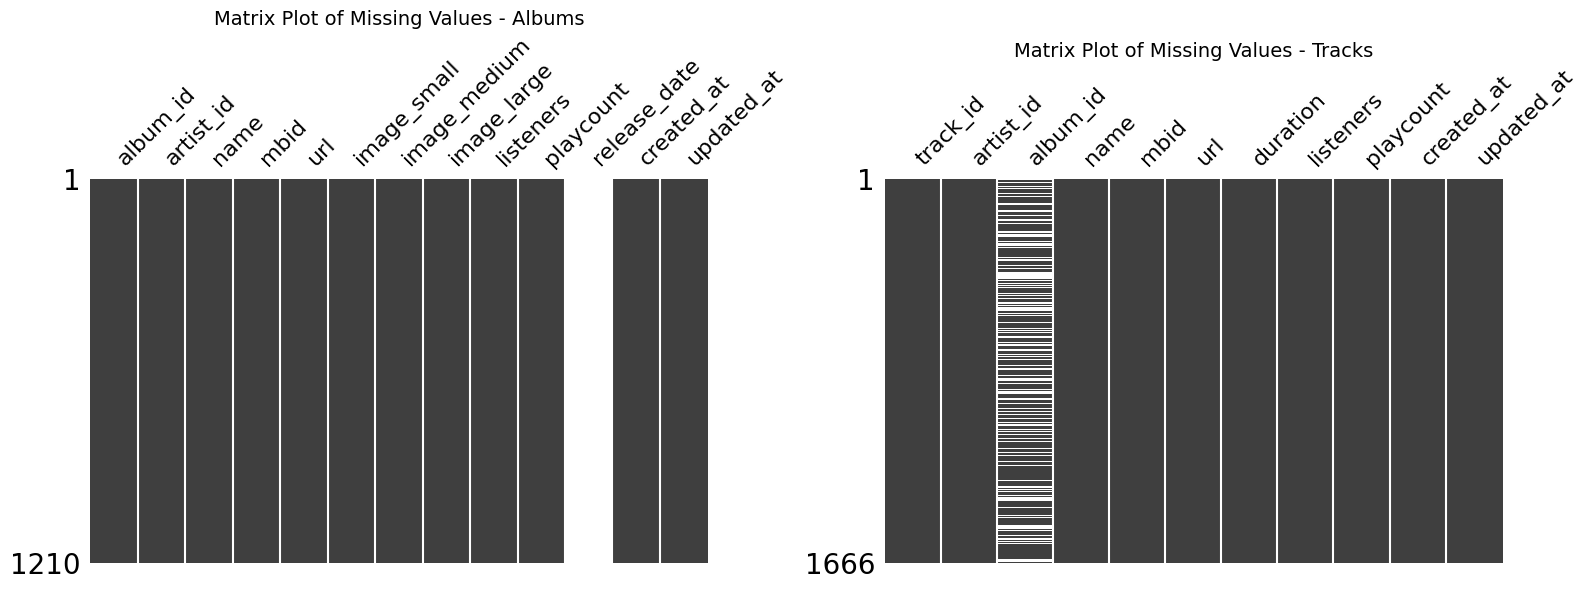

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Albums
msno.matrix(table_data['albums'], ax=ax1, sparkline=False)
ax1.set_title('Matrix Plot of Missing Values - Albums', fontsize=14)

# Tracks
msno.matrix(table_data['tracks'], ax=ax2, sparkline=False)
ax2.set_title('Matrix Plot of Missing Values - Tracks', fontsize=14)

plt.tight_layout()
plt.show()


*   **Albums**: All release dates are missing
*   **Tracks**: Some album ids are missing (as expected, see the data scraping notebook)

In [108]:
# Drop release_date column for Albums
table_data['albums'].drop(columns='release_date', inplace=True) # Modify the original df directly
# Verify that it looks good
table_data['albums'].info()

# Keep album_id column in Tracks for now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210 entries, 0 to 1209
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   album_id      1210 non-null   int64         
 1   artist_id     1210 non-null   int64         
 2   name          1210 non-null   object        
 3   mbid          1210 non-null   object        
 4   url           1210 non-null   object        
 5   image_small   1210 non-null   object        
 6   image_medium  1210 non-null   object        
 7   image_large   1210 non-null   object        
 8   listeners     1210 non-null   int64         
 9   playcount     1210 non-null   int64         
 10  created_at    1210 non-null   datetime64[ns]
 11  updated_at    1210 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 113.6+ KB


### Duplicates

In [109]:
print("Duplicate check across all tables:")
print("="*50)

for table_name, df in table_data.items():
    duplicate_count = df.duplicated().sum()
    total_rows = len(df)
    print(f"{table_name}: {duplicate_count} duplicates out of {total_rows} rows")

Duplicate check across all tables:
artists: 0 duplicates out of 659 rows
albums: 0 duplicates out of 1210 rows
tracks: 0 duplicates out of 1666 rows
tags: 0 duplicates out of 11764 rows
artist_tags: 0 duplicates out of 22852 rows
album_tags: 0 duplicates out of 8511 rows
track_tags: 0 duplicates out of 13499 rows
artist_similar: 0 duplicates out of 1048 rows
track_similar: 0 duplicates out of 992 rows
user_listening_history: 0 duplicates out of 2000 rows
user_top_artists: 0 duplicates out of 261 rows
user_top_albums: 0 duplicates out of 268 rows
user_top_tracks: 0 duplicates out of 300 rows


### Descriptive statistics

In [110]:
summary_stats = []

for table_name, df in table_data.items():
    stats = {
        'table': table_name,
        'rows': len(df),
        'columns': len(df.columns),
        'missing_values': df.isnull().sum().sum(),
        'duplicates': df.duplicated().sum(),
        'numeric_columns': len(df.select_dtypes(include=[np.number]).columns),
        'text_columns': len(df.select_dtypes(include=['object', 'string']).columns),
        'datetime_columns': len(df.select_dtypes(include=['datetime']).columns)
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
summary_df

,table,rows,columns,missing_values,duplicates,numeric_columns,text_columns,datetime_columns
0,artists,659,13,0,0,3,8,2
1,albums,1210,12,0,0,4,6,2
2,tracks,1666,11,560,0,6,3,2
3,tags,11764,9,0,0,3,4,2
4,artist_tags,22852,4,0,0,3,0,1
5,album_tags,8511,4,0,0,3,1,0
6,track_tags,13499,4,0,0,3,0,1
7,artist_similar,1048,4,0,0,3,0,1
8,track_similar,992,4,0,0,3,0,1
9,user_listening_history,2000,5,0,0,3,0,2


In [111]:
fig = px.bar(
    summary_df,
    x='table',
    y='rows',
    title='Rows by Table',
    text='rows'  # Show values on top of bars
)

fig.update_layout(
    xaxis_title='Table',
    yaxis_title='Count',
    xaxis=dict(tickangle=45),
    showlegend=False,
    yaxis=dict(range=[0, summary_df['rows'].max() * 1.1])  # Add 10% padding to top
)

# Format the text on bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

fig.show()

Please note that the timestamps are in UTC time (need adjustment to be in Paris time).

In [112]:
# Create listening history dataframe (track and artist names)
listening_df = table_data['user_listening_history'].merge(
    table_data['tracks'][['track_id', 'name', 'artist_id']],
    on='track_id',
    how='left'
).merge(
    table_data['artists'][['artist_id', 'name']],
    on='artist_id',
    how='left',
    suffixes=('_track', '_artist')
)

# Rename columns
listening_df = listening_df[['listened_at', 'name_track', 'name_artist']].rename(columns={
    'name_track': 'track_name',
    'name_artist': 'artist_name'
})

# Convert to datetime and handle timezone
listening_df['listened_at'] = pd.to_datetime(listening_df['listened_at'])
if listening_df['listened_at'].dt.tz is None:
    listening_df['listened_at'] = listening_df['listened_at'].dt.tz_localize('UTC')

# Add Paris time column
listening_df['listened_at_paris'] = listening_df['listened_at'].dt.tz_convert('Europe/Paris')

# Sort by listened_at descending
listening_df = listening_df.sort_values('listened_at', ascending=False)

# Add time-based features using Paris time
listening_df['hour_of_day_paris'] = listening_df['listened_at_paris'].dt.hour
listening_df['day_of_week'] = listening_df['listened_at_paris'].dt.day_name()
listening_df['month'] = listening_df['listened_at_paris'].dt.month

# Convert to ordered categorical with proper day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

listening_df['day_of_week'] = pd.Categorical(
    listening_df['day_of_week'],
    categories=day_order,
    ordered=True
)

listening_df.head()

,listened_at,track_name,artist_name,listened_at_paris,hour_of_day_paris,day_of_week,month
0,2025-05-07 08:39:43+00:00,Emily I'm Sorry,boygenius,2025-05-07 10:39:43+02:00,10,Wednesday,5
1,2025-05-07 08:36:23+00:00,$20,boygenius,2025-05-07 10:36:23+02:00,10,Wednesday,5
2,2025-05-07 08:35:03+00:00,Without You Without Them,boygenius,2025-05-07 10:35:03+02:00,10,Wednesday,5
3,2025-05-07 08:32:06+00:00,Sidelines,Phoebe Bridgers,2025-05-07 10:32:06+02:00,10,Wednesday,5
4,2025-05-07 08:27:36+00:00,Motion Sickness,Phoebe Bridgers,2025-05-07 10:27:36+02:00,10,Wednesday,5


In [113]:
# Get hour counts using Paris time
hour_counts_paris = listening_df['hour_of_day_paris'].value_counts().sort_index()

# Create a DataFrame for plotly
hour_data = pd.DataFrame({
    'hour': hour_counts_paris.index,
    'count': hour_counts_paris.values
})

fig = px.bar(
    hour_data,
    x='hour',
    y='count',
    title='Listening Activity by Hour of Day (Paris Time)'
)

fig.update_layout(
    xaxis_title='Hour (Paris Time)',
    yaxis_title='Number of Tracks',
    xaxis=dict(tickmode='linear', tick0=0, dtick=1)
)

fig.show()

In [114]:
# Create a timeline of your listening history
listening_df['date'] = listening_df['listened_at_paris'].dt.date  # Use Paris time
listening_df['date'] = pd.to_datetime(listening_df['date']) # date should be datetime

daily_counts = listening_df.groupby('date').size().reset_index(name='plays')

fig = px.bar(
    daily_counts,
    x='date',
    y='plays',
    title='Daily Listening Activity'
)

fig.update_traces(
    hovertemplate='<b>Date:</b> %{x}<br><b>Tracks played:</b> %{y}<extra></extra>'
    # Removed line=dict(width=2) as it's not applicable to bar charts
)

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Number of Tracks Played',
    width=1000,
    height=400,
    showlegend=False
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.3)')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.3)')

fig.show()

In [115]:
# Create genre dataframe
genre_df = table_data['tags'].merge(
    table_data['artist_tags'],
    on='tag_id',
    how='inner'
).groupby('name', as_index=False).agg({
    'artist_id': 'nunique'  # Count distinct artists
}).rename(columns={
    'name': 'tag_name',
    'artist_id': 'artist_count'
})

# Filter genres with more than 5 artists
genre_df = genre_df[genre_df['artist_count'] > 5]

# Sort by artist count descending and take top 20
genre_df = genre_df.sort_values('artist_count', ascending=False).head(20)

# Visualize with plotly
fig = px.bar(genre_df, x='tag_name', y='artist_count',
             title='Top 20 Genres in Your Collection')
fig.update_layout(xaxis_title='Genre', yaxis_title='Number of Artists')
fig.show()

Most genres are self explanatory, but some are rather user behavior tags, e.g.:


*   **seen live** : users can tag artists with "seen live" to indicate that they've attended a live performance or concert by that artist.
*   **All** : a catch-all or general bookmark tag used by users when they can't decide on a specific genre, want to indicate an artist fits multiple genres, or simply use it for personal organization purposes.


In [116]:
# ALL tags in your database (not filtered for top artists as in the figure above)
all_tags = table_data['tags']['name'].tolist()
print(f"Total tags in database: {len(all_tags)}")
print("All tags:", all_tags)

Total tags in database: 11764
All tags: ['seen live', 'indie', 'swedish', 'Dreamy', 'melancholic', 'Swedish Pop', 'pop', 'indiepop', 'scandinavian', 'Sweden', 'All', 'acustica', 'chillout', 'new age', 'renato ventura saids bravo', 'chill', 'arabic', 'New Zealand', 'lounge', 'Oriental', 'kurdish', 'lounge-radio', 'central asia', 'Kyrgyzstan', 'trance', 'electronic', 'electronica', 'vocal', 'ambient', 'female vocalists', 'downtempo', 'world', 'club', 'chill-out', 'chill out', 'rai', 'Kazakhstan', 'Syrian', 'musique arabe', 'musique occidantale', 'nouri', 'indie pop', 'austrian', 'singer-songwriter', 'german', 'Stones throw', 'Austria', 'art pop', 'spotify', 'music i tried but didnt like', 'pop vocals', '4-25', 'jazz', 'instrumental', 'piano', 'calm', 'american', 'jazzy', 'jazz piano', 'North Carolina', 'piano jazz', 'pianist', 'solo piano', 'piano player', 'North American', 'funk_add_to_lidarr_batch_20', 'Classical', 'Czech', 'modern classical', 'opera', 'composer', 'modern', 'czech comp

### Relationships between columns

In [117]:
# Simple function to get a quick overview
def quick_relationship_summary(table_data):
    print(f"\n=== NUMERIC RELATIONSHIPS ===")
    # Quick correlation check for main tables
    main_tables = ['artists', 'albums', 'tracks', 'user_listening_history']
    for table_name in main_tables:
        if table_name in table_data:
            df = table_data[table_name]
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 1:
                print(f"\n{table_name} numeric correlations:")
                print(df[numeric_cols].corr().round(3))

quick_relationship_summary(table_data)


=== NUMERIC RELATIONSHIPS ===

artists numeric correlations:
           artist_id  listeners  playcount
artist_id      1.000      0.083      0.035
listeners      0.083      1.000      0.809
playcount      0.035      0.809      1.000

albums numeric correlations:
           album_id  artist_id  listeners  playcount
album_id      1.000      0.026     -0.064     -0.038
artist_id     0.026      1.000      0.057      0.010
listeners    -0.064      0.057      1.000      0.851
playcount    -0.038      0.010      0.851      1.000

tracks numeric correlations:
           track_id  artist_id  album_id  duration  listeners  playcount
track_id      1.000     -0.009    -0.006     0.028     -0.038     -0.043
artist_id    -0.009      1.000     0.010    -0.029     -0.009     -0.041
album_id     -0.006      0.010     1.000     0.011      0.039      0.005
duration      0.028     -0.029     0.011     1.000      0.084      0.050
listeners    -0.038     -0.009     0.039     0.084      1.000      0.869
pla

Correlation between *listeners* vs *playcount*  across all entities (artists: 0.809, albums: 0.851, tracks: 0.869). Popular music (e.g. with more listeners) gets played more often. The strongest relationship is for tracks (individual track popularity seems to be more tightly coupled than artist/album popularity).



In [118]:
def plot_cardinality(table_data):
    # Get cardinality for all columns
    data = []
    for table, df in table_data.items():
        for col in df.select_dtypes(exclude=['datetime']).columns:
            data.append({
                'table': table, 'column': col,
                'unique': df[col].nunique(), 'total': len(df)
            })

    cardinality_df = pd.DataFrame(data)
    cardinality_df['ratio'] = cardinality_df['unique'] / cardinality_df['total']

    # Plot
    fig = px.scatter(cardinality_df, x='total', y='unique', color='table',
                     size='ratio', hover_data=['column'],
                     title='Cardinality: Unique Values vs Total Rows')

    # Add diagonal reference line
    max_val = max(cardinality_df['total'].max(), cardinality_df['unique'].max())
    fig.add_shape(type="line", x0=0, y0=0, x1=max_val, y1=max_val,
                  line=dict(color="gray", dash="dash"))

    fig.show()

plot_cardinality(table_data)

### Network analysis

In [119]:
# Extract artist similarity data using pandas merges
similarity_df = table_data['artist_similar'].merge(
    table_data['artists'][['artist_id', 'name']],
    left_on='artist_id',
    right_on='artist_id',
    how='inner'
).merge(
    table_data['artists'][['artist_id', 'name']],
    left_on='similar_artist_id',
    right_on='artist_id',
    how='inner',
    suffixes=('_artist', '_similar')
)

# Select and rename columns to match original query
similarity_df = similarity_df[['name_artist', 'name_similar', 'match_score']].rename(columns={
    'name_artist': 'artist',
    'name_similar': 'similar_artist'
})

# Filter for match_score > 0.7 (WHERE clause)
similarity_df = similarity_df[similarity_df['match_score'] > 0.7]

print(f"Found {len(similarity_df)} artist similarity relationships with match_score > 0.7")
print(similarity_df.head(n=20))

Found 499 artist similarity relationships with match_score > 0.7
                  artist         similar_artist  match_score
0           Leoš Janáček       Benjamin Britten     1.000000
1           Leoš Janáček       Sergei Prokofiev     0.795431
2     Alberto Rabagliati         Ernesto Bonino     1.000000
3     Alberto Rabagliati          Natalino Otto     0.913133
4     Alberto Rabagliati           Trio Lescano     0.833907
5     Alberto Rabagliati             Carlo Buti     0.711615
11              Tortoise      Do Make Say Think     0.870639
14    Domenico Scarlatti  Johann Sebastian Bach     0.977581
15    Domenico Scarlatti     Alexander Scriabin     0.848852
16    Domenico Scarlatti      Felix Mendelssohn     0.783345
17              Jamie xx                Caribou     1.000000
18           Nilla Pizzi     Alberto Rabagliati     0.968982
19           Nilla Pizzi         Ernesto Bonino     0.888629
20           Nilla Pizzi          Natalino Otto     0.801915
25  Charlotte Day Wi

In [120]:
# Create network graph
G = nx.from_pandas_edgelist(
    similarity_df,
    source='artist',
    target='similar_artist',
    edge_attr='match_score'
)

print(f"Network has {G.number_of_nodes()} artists and {G.number_of_edges()} connections")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

# Find most connected artists
degree_centrality = nx.degree_centrality(G)
top_connected = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Most connected artists:", top_connected)

# Get actual connection counts instead of normalized centrality
degree_dict = dict(G.degree())
top_connected_raw = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print("Most connected artists (raw connection count):")
for artist, connections in top_connected_raw:
    print(f"  {artist}: {connections} connections")

# Check if the network has multiple components
components = list(nx.connected_components(G))
print(f"\nNetwork has {len(components)} connected components")
print(f"Largest component has {len(max(components, key=len))} artists")

Network has 328 artists and 377 connections
Average degree: 2.30
Most connected artists: [('Coma_Cose', 0.03363914373088685), ('Kyle Mendes Jazz Trio', 0.027522935779816515), ('Sydney Taylor Band', 0.027522935779816515), ('Katy Healy', 0.027522935779816515), ('Art Silver Trio', 0.024464831804281346)]
Most connected artists (raw connection count):
  Coma_Cose: 11 connections
  Kyle Mendes Jazz Trio: 9 connections
  Sydney Taylor Band: 9 connections
  Katy Healy: 9 connections
  Art Silver Trio: 8 connections
  Lyla Lee Band: 8 connections
  Fedez: 8 connections
  Milad Greenland: 8 connections
  Dennis Riley-Jones: 8 connections
  Barry Snyder Band: 7 connections

Network has 70 connected components
Largest component has 47 artists


**How do the artists I actually listen to relate to each other according to Last.fm's global similarity data?**

Key findings from network analysis focused on artist similarity relationships (high-confidence connections with match score > 0.7, based on Last.fm API similarity score):

* 328 artists connected through 377 similarity relationships, with an average of 2.3 connections per artist
* Fragmented communities: network consisting of 70 separate components, with the largest one containing 47 artists
* Jazz ensembles and Italian artists serve as the most connected nodes

The high similarity threshold preserves only the strongest musical releationships, creating meaningful but isolated communities that aligh with musical genres, eras, and regional scenes.

In [121]:
def plot_network(G, genre_df):
    # Get top 20 tags excluding non-musical ones
    excluded_tags = ['all', 'seen live']
    top_tags = genre_df[~genre_df['tag_name'].str.lower().isin([t.lower() for t in excluded_tags])].head(20)

    # Create tag mappings
    symbols = ['circle', 'square', 'diamond', 'triangle-up', 'triangle-down',
               'pentagon', 'hexagon', 'star', 'cross', 'x', 'circle-open',
               'square-open', 'diamond-open', 'triangle-up-open', 'triangle-down-open',
               'pentagon-open', 'hexagon-open', 'star-open', 'bowtie', 'hourglass']

    tag_to_symbol = dict(zip(top_tags['tag_name'].str.lower(), symbols[:len(top_tags)]))

    # Get artist primary tags (vectorized)
    artist_tags = (table_data['artist_tags']
                   .merge(table_data['tags'][['tag_id', 'name']], on='tag_id')
                   .merge(table_data['artists'][['artist_id', 'name']], on='artist_id', suffixes=('_tag', '_artist'))
                   [lambda x: x['name_tag'].str.lower().isin(tag_to_symbol.keys())]
                   .loc[lambda x: x.groupby('name_artist')['count'].idxmax()]
                   .set_index('name_artist')['name_tag'].str.lower().to_dict())

    # Setup network
    for edge in G.edges(data=True):
        G[edge[0]][edge[1]]['weight'] = (edge[2]['match_score'] ** 3) * 20

    pos = nx.spring_layout(G, k=0.3, iterations=200, seed=42, weight='weight', threshold=1e-6)
    degree_dict = dict(G.degree())

    # Create edges
    edge_coords = [(pos[edge[0]], pos[edge[1]]) for edge in G.edges()]
    edge_x = [coord for (x0,y0), (x1,y1) in edge_coords for coord in [x0, x1, None]]
    edge_y = [coord for (x0,y0), (x1,y1) in edge_coords for coord in [y0, y1, None]]

    # Group nodes by tag
    node_data = [(node, pos[node], degree_dict[node], artist_tags.get(node, 'other'))
                 for node in G.nodes()]

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray',
              'olive', 'cyan', 'magenta', 'yellow', 'navy', 'lime', 'maroon',
              'teal', 'silver', 'gold', 'indigo', 'coral']

    # Create plot
    fig = go.Figure()

    # Add edges
    fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines',
                           line=dict(width=1, color='lightgray'),
                           hoverinfo='none', showlegend=False))

    # Add nodes by tag (vectorized grouping)
    for i, (tag, group) in enumerate(pd.DataFrame(node_data, columns=['node', 'pos', 'degree', 'tag'])
                                     .groupby('tag')):
        if len(group) == 0:
            continue

        x_coords = [pos[0] for pos in group['pos']]
        y_coords = [pos[1] for pos in group['pos']]
        sizes = [max(deg * 3 + 10, 15) for deg in group['degree']]
        hover_text = [f"<b>{node}</b><br>Connections: {deg}<br>Primary tag: {tag}"
                     for node, deg in zip(group['node'], group['degree'])]

        fig.add_trace(go.Scatter(
            x=x_coords, y=y_coords, mode='markers',
            marker=dict(size=sizes, color=colors[i % len(colors)],
                       symbol=tag_to_symbol.get(tag, 'circle'),
                       line=dict(width=1, color='black')),
            hovertext=hover_text, hoverinfo='text',
            name=f'{tag.title()} ({len(group)})', showlegend=True
        ))

    # Add text labels
    all_x, all_y = zip(*[pos[node] for node in G.nodes()])
    text_labels = [node[:15] + '...' if len(node) > 15 else node for node in G.nodes()]

    fig.add_trace(go.Scatter(x=all_x, y=all_y, mode='text', text=text_labels,
                           textposition="middle center", textfont=dict(size=7, color='black'),
                           hoverinfo='none', showlegend=False))

    fig.update_layout(
        title='Artist Similarity Network<br><sub>Zoom in to explore clusters of similar artists.<br></sub><sub>Shape = Primary Tag, Color = Tag Group, Size = Connections. Note: The "other" tag is added here for artists that do not have top 20 tags. </sub>',
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        width=1200, height=1000, showlegend=True,
        legend=dict(x=1.02, y=1, xanchor='left'), hovermode='closest'
    )

    fig.show()

    # Print mapping (vectorized)
    print("Top tags and their symbols:")
    for _, row in top_tags.iterrows():
        print(f"  {row['tag_name']}: {tag_to_symbol[row['tag_name'].lower()]} ({row['artist_count']} artists)")

plot_network(G, genre_df)

Top tags and their symbols:
  pop: circle (268 artists)
  indie: square (218 artists)
  alternative: diamond (206 artists)
  electronic: triangle-up (205 artists)
  jazz: triangle-down (192 artists)
  rock: pentagon (186 artists)
  experimental: hexagon (180 artists)
  instrumental: star (154 artists)
  indie pop: cross (153 artists)
  singer-songwriter: x (148 artists)
  USA: circle-open (135 artists)
  folk: square-open (134 artists)
  ambient: diamond-open (132 artists)
  american: triangle-up-open (132 artists)
  male vocalists: triangle-down-open (131 artists)
  female vocalists: pentagon-open (127 artists)
  indie rock: hexagon-open (125 artists)
  00s: star-open (107 artists)


## Close connection

In [122]:
# Close the connection
conn.close()
print("\nDatabase connection closed.")


Database connection closed.


# **Summary of Pandas Tables**

**Original Database Tables (imported from SQLite)**

*  table_data['artists'] - artists with metadata (name, mbid, url, images, listeners, playcount, bio, timestamps)       
* table_data['albums'] - albums with metadata (name, artist_id, mbid, url, images, listeners, playcount, timestamps)
* table_data['tracks'] - tracks with metadata (name, artist_id, album_id, mbid, url, duration, listeners, playcount, timestamps)
* table_data['tags'] - tags with metadata (name, url, reach: number of unique users who have applied the tag, taggings: the total umber of times this tag has been applied across all users and all artists/albums/tracks, wiki content, timestamps)
* table_data['artist_tags'] - artist-tag relationships (artist_id, tag_id, count, created_at)
* table_data['album_tags'] - album-tag relationships (album_id, tag_id, count, created_at)
* table_data['track_tags'] - track-tag relationships (track_id, tag_id, count, created_at)
* table_data['artist_similar'] - artist similarity relationships (artist_id, similar_artist_id, match_score, created_at)
* table_data['track_similar'] - track similarity relationships (track_id, similar_track_id, match_score, created_at)
* table_data['user_listening_history'] - listening records (history_id, track_id, listened_at, is_now_playing, created_at)
* table_data['user_top_artists'] - top artist rankings (user_top_artist_id, artist_id,  time_period: ['overall', '7day', '1month', '3month', '6month', '12month'], rank, playcount, timestamps)
* table_data['user_top_albums'] - top album rankings (user_top_album_id, album_id, time_period (as above), rank, playcount, timestamps)
* table_data['user_top_tracks'] - top track rankings (user_top_track_id, track_id, time_period (as above), rank, playcount, timestamps)

**Derived Tables (this notebook)**

* summary_df - Database overview statistics (table, rows, columns, 	missing_values, duplicates, numeric_columns, text_columns, datetime_columns)
* listening_df - Enhanced listening history with Paris timezone conversion, artist/track names, and time-based features (listened_at (UTC), track_name, 	artist_name, listened_at_paris, hour_of_day, day_of_week, month, date)
* genre_df - Top 20 genres by artist count (filtered for >5 artists), including behavioral tags like 'All' and 'seen live' (only filtered for network visualization above)
* similarity_df - Artist similarity data (artist, similar_artist, match_score)

**Notes**

* Timezones: All timestamp are UTC unless else is stated in the column name (only listened_at_paris and hour_of_day_paris is Paris time)
* Data cleaning: release_date column dropped from albums (all null values)